# DMSP-OLS intercalibration (10 min)

As described in {doc}`mod1_1_introduction_to_nighttime_light_data`, the DMSP-OLS sensors lacked on-board calibration, so there are noticeable variations from satellite to satellite. In order to adequately compare nighttime lights data across satellites, they must be calibrated. 

In this exercise, we're going to calibrate DMSP-OLS data based on a method established by Elvidge et al. (2009) {cite}`elvidge2009fifteen`.

**Prerequisites:**
- Make sure you have Python, Jupyter notebooks, and `ee` and `geemap` installed and are familiar with these packages
- If not, you'll want to review: 
    - {doc}`mod1_3_getting_started_with_Python`
    - {doc}`mod1_4_introduction_to_Jupyter_notebooks`
    - {doc}`mod1_5_introduction_to_GEE`
- You may also want to try this exercise to get familiar with GEE and the Python `geemap` and `ee` libraries:
    - {doc}`mod1_7_practical_exercise-image_visualization`

**Our tasks in this exercise:**
1. Reviewing the calibration coefficients and formula used by Elvidge
2. Apply calibration steps to a single image, 1996
3. Compare the differences between calibrated and non-calibrated images with a histogram.
4. Create a function that dynamically applies the calibration depending on a given satellite/year input.
5. Compare the difference in calibrated and non-calibrated time series.

## Reviewing the calibration coefficients and formula

The initial paper {cite}`elvidge2009fifteen` cited outlines the steps the authors took, if you're interested in the details. What's important for our purposes here, is that they derived a set of coefficients that, when applied to each satellite in the DMSP series, provides a more stable calibrated measure of nighttime lights that corrects for the sensor variation and allows us to more accurately compare data.

These coefficients map to the formula:
$$X' = C_{0} + C_{1}*X + C_{2}*X^{2}$$

Where:
- X: the input image, represented as a 2-dimensional matrix (recall these images are panchromatic so there is only one channel of light)
- $C_{0}, C_{1}, C_{2}$: the calibration coefficients that are assigned to each satellite
- X': the calibrated image

The initial paper was written in 2009, prior to the final year of DMSP-OLS. We can get a more recent series of coefficients (through 2012) here (using the same method):

```{figure} img/mod2-2-intercalib_coef.png
---
name: intercalib_coefficients
---
DMSP-OLS intercalibration {cite}`jiang2017assessing`
```

**Note:** this method is fine for purposes of this tutorial, but it's worth mentioning that there are several other methods to conduct this calibration as well.


## Apply calibration to a single image, 1996

### Initialize object and visualization

As previous tutorials, we'll initialize a `geemap` object, get the DMSP-OLS 1996 composite and visualize it.

For this exercise, we'll use the "stable_lights" band.

In [1]:
# import geemap and ee for our Python session
import geemap, ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# set our initial map parameters for Washington, DC
center_lat = 38.9072
center_lon = -77.0369
zoomlevel=10

# initialize our map
dmspMap = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)
dmspMap.add_basemap('SATELLITE')

# get 1996 composite, apply mask, and add as layer
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
dmspMap.addLayer(dmsp1996.mask(dmsp1996), {}, "DMSP-OLS 1996", opacity=0.75)

In [2]:
# display our map
dmspMap

Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

For 1996, there is only one satellite, F12, so we can reference the appropriate coefficients for F121996 from our table above:

- $C_{0}$ = -0.0959
- $C_{1}$ = 1.2727
- $C_{2}$ = -0.0040

GEE has an `.expression()` method which allows us to plug our formula in with these coefficients and get an adjusted image.

We add our coefficients to the appropriate terms of the polynomial and set our input image as the X variable.

In [3]:
dmsp1996_clbr = dmsp1996.expression('-0.0959 + (1.2727 * X) + (-0.0040 * X * X)',{'X':dmsp1996.select('stable_lights')})

This calibration adjusts the value of the Digital Number (DN)and in some cases, it will cause a pixel's value to go above 63. We also have pixels with DN's of less than 6. We'll cap the DNs at 63 and replace any values below 6 with 0s.

Let's create a clipped version of the original layer just for comparison.

In [4]:
dmsp1996_clbr = dmsp1996_clbr.where(dmsp1996_clbr.gt(63),63).where(dmsp1996_clbr.lte(6),0)
dmsp1996_clip = dmsp1996.where(dmsp1996.gt(63),63).where(dmsp1996.lte(6),0)

## Compare the calibrated images with a histogram

You can add the calibrated layer to your map if you'd like, but the best way to compare a single image is looking at the distribution of the DN values. Google Earth Engine has options for plotting images in the JavaScript editor, but they are not available for the Python API. So we'll have to do a couple steps to make a plot.

To show the benefit of interactive plots, we'll draw a polygon in our map (you can do this in GEE's editor as well). To this, go to your map and select the "rectangle" option in the toolbar to the left (see image):

![rectangeicon](img/mod2-2-rectangleicon.png)

Then click with your mouse some point in your map, hold the button, and drag to create a rectangle.

For example, here's a rectangle we created that bounds the greater Washington, DC metro area:

![rectange](img/mod2-2-rectangle.png)

#### Converting an image to a numpy array

After creating this drawing, you can use the Google Earth Engine's Python API `ee.Image.sampleRectangle()` method to convert a specific map object, such as a map layer, to a numerical array that we can plot. Conveniently, `geemap` has a method `ee_to_numpy` that also converts the array to a numpy array.

The `geemap.ee_to_numpy` method takes as its first argument the specific `ee` object you want to convert to an array -- in this case we'll extract both our `dmsp1996_clip` (non-calibrated and clipped) and our `dmsp1996_clbr` (calibrated) layers.

The `geemap.ee_to_numpy` method also takes a `region` argument that defines the region you are creating your array from. (For good reason, the API restricts the size of data you can download so you can't convert the entire raster file to an array directly into your notebook).

Now we can get the region defined by the rectangle we just drew by calling `geemap.Map`'s `.draw_last_json` method and getting the "geometry" value.

In [5]:
# define our geometry using the rectangle we just drew
myPolyGeom = dmspMap.draw_last_json.get('geometry')

# convert both the clipped DMSP-OLS 1996 layer and the calibrated layer to a numpy array
dmsp1996_arr = geemap.ee_to_numpy(dmsp1996_clip, region=myPolyGeom)
dmsp1996_clbr_arr = geemap.ee_to_numpy(dmsp1996_clbr, region=dmspMap.draw_last_json['geometry'])

#### Use Python's `seaborn` package to plot the distribution

We'll get into the plotting packages available in a later tutorial when we focus on creating plots. For now, we'll just use the `seaborn` package and the `matplotlib.pyplot` packages to create a simple probability density plot that compares the distribution of our two layers.

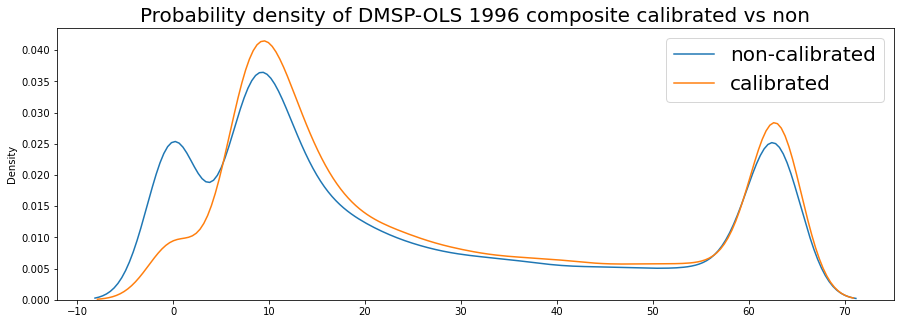

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1996_arr.flatten(), label='non-calibrated',legend=True, ax=ax)
sns.kdeplot(dmsp1996_clbr_arr.flatten(), label='calibrated',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of DMSP-OLS 1996 composite calibrated vs non', fontsize=20);

**Brief observations:** You can see that while both layers show a similar distribution, the calibration impacts the distribution (it seems to shift the distribution rightward, i.e. increases the values somewhat).

## Thinking programmically: creating a function to convert all images in the series

We just calibrated a single annual composite by hard-coding the expression, but there's a better way to do this by creating a function. This addresses two key issues:
- functions are more efficient and reduce repetition
- more importantly, they reduce the chance of human error when hand-writing or cutting-and-pasting data, such as our calibration coefficients or satellite names.

We've created a `.csv` file of our calibration coeffients. We're going to create a function that takes as its argument a particalar satellite-year name (such as you find as the image id in GEE), looks up that satellites coefficients from our table, applies them to the image, and finally, clips the low and high DN values.

We can then use this function on our entire ImageCollection as a custom function.

#### Define functions that operate on a single image

In [28]:
# load the coefficient reference file
import pandas as pd
coef = pd.read_csv('files/Elvidge_DMSP_intercalib_coef.csv')

# define a function that takes an image, gets its name, and returns its coefficients
def get_coefs(img, coefdata=coef):
    imgID = img.id().getInfo()
    idx = coefdata['satellite']+coefdata['year'].astype(str)==imgID
    return coefdata.loc[idx, ['c0','c1','c2']].values[0]

# define a function that wraps the ee.Image native "expression" function 
# and passess the image coefficients as arguments to return the calibrated image
def calibrate_img(img):
    c0, c1, c2 = get_coefs(img)
    return img.expression("c0 + (c1 * X) + (c2 * X**2)", {'X':img, 'c0':c0, 'c1':c1, 'c2':c2})

# define a function that clips images
def clip_img(img, upper_thresh=63, upper_set=63, lower_thresh=6, lower_set=0):
    return img.where(img.gt(upper_thresh),upper_set).where(img.lte(lower_thresh),lower_set)

# wrap these in a single function using defaults
def calibrate_and_clip(img):
    return clip_img(calibrate_img(img))

#### Map expression to a collection of images

In [29]:
# get dmsp collection (getting "stable_lights" band)
dmsp = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS").select('stable_lights')

dmsp_calibrated = dmsp.map(calibrate_and_clip)

EEException: ValueNode is empty

In [23]:
dmsp1996a = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
dmsp1996b = calibrate_and_clip(dmsp1996a)
dmsp1996a = clip_img(dmsp1996a)

dmsp1996a_arr = geemap.ee_to_numpy(dmsp1996a, region=myPolyGeom)
dmsp1996b_arr = geemap.ee_to_numpy(dmsp1996b, region=myPolyGeom)

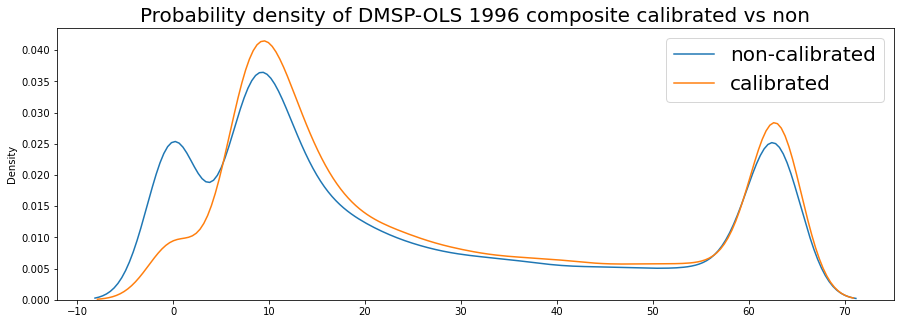

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1996a_arr.flatten(), label='non-calibrated',legend=True, ax=ax)
sns.kdeplot(dmsp1996b_arr.flatten(), label='calibrated',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of DMSP-OLS 1996 composite calibrated vs non', fontsize=20);

In [63]:
clip_img(dmsp1996b).getInfo()

{'type': 'Image',
 'bands': [{'id': 'constant',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -260.1959,
    'max': 324.4426},
   'crs': 'EPSG:4326',
   'crs_transform': [0.0083333333,
    0,
    -180.00416666665,
    0,
    -0.0083333333,
    75.00416666665]}]}

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```